In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib_fontja # グラフに日本語を表示するのに必要
import nashpy as nash
from pokemon_iyasi1on1.db import get_species
from pokemon_iyasi1on1.model import NatureTarget, Poke, PokeBreeding, PokeStrategy

In [2]:
ds = pickle.load(open("data/monte_carlo_win_table.pkl","rb"))

In [3]:
n_breedings = len(ds["breedings"])

In [4]:
# 勝率テーブル作成
winrates = np.zeros((n_breedings, n_breedings))
for match, winrate in ds["results"]:
    # 上三角だけ情報が入っている
    winrates[match] = winrate
winrates += np.tril(1.0 - winrates.T, k=-1) # 下三角を作成、k=-1: 対角成分を除去
winrates += np.eye(n_breedings) * 0.5 # 自分自身は勝率0.5

In [5]:
# 利得行列に変換(-1~1)
payoffs = (winrates - 0.5) * 2

In [6]:
%%time
rps = nash.Game(payoffs)
strt, _ = rps.linear_program() # 2プレイヤーの戦略が出るが対称なので1つだけ取得

CPU times: user 1.85 s, sys: 210 ms, total: 2.06 s
Wall time: 2.15 s


In [7]:
def breedings_str(b):
    s = f"{get_species(b.no).name.replace('のすがた','')}"
    match b.strategy:
        case PokeStrategy.VEST:
            s += ",チョッキ"
        case PokeStrategy.LEFTOVER:
            s += ",たべのこし"
    s += f",H{b.ev_hp},A{b.ev_a},B{b.ev_b},S{b.ev_s}"
    match b.nature_up:
        case NatureTarget.A:
            s += ",A↑"
        case NatureTarget.B:
            s += ",B↑"
        case NatureTarget.S:
            s += ",S↑"
    match b.nature_down:
        case NatureTarget.A:
            s += ",A↓"
        case NatureTarget.B:
            s += ",B↓"
        case NatureTarget.S:
            s += ",S↓"
    if b.ev_s == 0 and b.iv_s == 0 and b.nature_down == NatureTarget.S:
        s += ",最遅"
    return s

In [8]:
# ナッシュ均衡で選出確率が正の値になった構築を表示
for idx in np.argsort(-strt):
    if strt[idx] <= 0.0:
        continue
    s = breedings_str(ds["breedings"][idx])
    print(f"{strt[idx]*100:.2f}%, {s}")

21.99%, ブリムオン,チョッキ,H60,A252,B196,S0,B↑,S↓,最遅
15.11%, ヤドラン,チョッキ,H4,A252,B252,S0,B↑,S↓,最遅
14.46%, エルレイド,チョッキ,H4,A252,B252,S0,A↑
11.26%, ヤドラン,チョッキ,H252,A4,B252,S0,B↑,S↓,最遅
10.20%, ヤドラン(ガラル),チョッキ,H4,A252,B252,S0,A↑,S↓,最遅
7.56%, ヤドラン,たべのこし,H252,A4,B252,S0,B↑,S↓,最遅
5.74%, ルカリオ,チョッキ,H4,A252,B252,S0,A↑
4.86%, ブリムオン,チョッキ,H252,A4,B252,S0,B↑,S↓,最遅
3.07%, ブリムオン,チョッキ,H252,A4,B252,S0,A↑,S↓,最遅
3.00%, ヤドン,チョッキ,H4,A252,B252,S0,B↑,S↓,最遅
2.76%, ヤドラン(ガラル),チョッキ,H4,A252,B252,S0,B↑,S↓,最遅


In [9]:
strt_str_list = []
strt_idxs = []
for idx in np.argsort(-strt):
    if strt[idx] <= 0.0:
        continue
    strt_idxs.append(idx)
    s = breedings_str(ds["breedings"][idx])
    strt_str_list.append(s)

In [10]:
def display_heatmap(cmap="coolwarm", savefig=None):
    
    # 戦略の数
    n = len(strt_idxs)
    
    # 空の利得行列を作成
    payoff_matrix = payoffs[strt_idxs][:, strt_idxs]
    
    # ヒートマップを描画
    fig, ax = plt.subplots()
    cax = ax.matshow(payoff_matrix, cmap=cmap)
    plt.colorbar(cax)
    
    # 軸のラベルを設定
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(strt_str_list, rotation=90, ha="left")
    ax.set_yticklabels(strt_str_list)
    
    # 数値ラベルを追加
    for i in range(n):
        for j in range(n):
            if cmap == "coolwarm":
                color = "black"
            else:
                color = 'black' if payoff_matrix[i, j] > -0.1 else 'white'
            # 見づらいので消した
            # ax.text(j, i, f"{payoff_matrix[i, j]:.3f}", ha='center', va='center', color=color)
    
    plt.title("Payoff Matrix of Strategies")
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    plt.show()


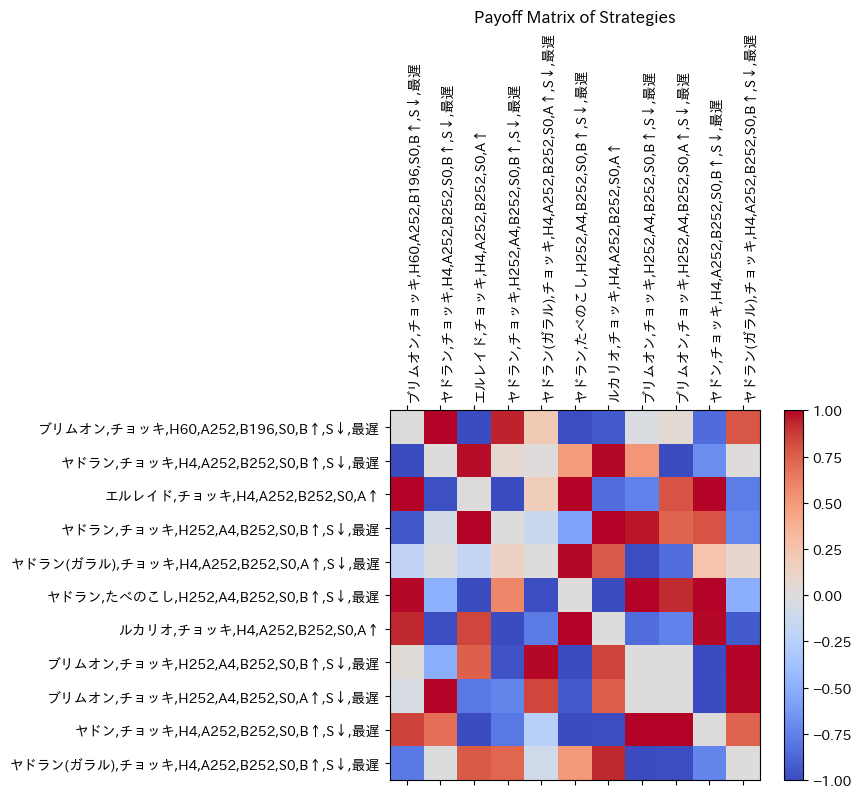

In [11]:
display_heatmap(savefig="payoff_nash_strategies.png")